# Phase 2: Hyperparameter Tuning with Optuna


```
# This is formatted as code
```



## 1. Setup & Configuration

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import random
from copy import deepcopy
import json
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import cv2

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Base Configuration
NUM_CLASSES = 20

CLASS_NAMES = {
    0: 'Groove_billed_Ani', 1: 'Red_winged_Blackbird', 2: 'Rusty_Blackbird',
    3: 'Gray_Catbird', 4: 'Brandt_Cormorant', 5: 'Eastern_Towhee',
    6: 'Indigo_Bunting', 7: 'Brewer_Blackbird', 8: 'Painted_Bunting',
    9: 'Bobolink', 10: 'Lazuli_Bunting', 11: 'Yellow_headed_Blackbird',
    12: 'American_Crow', 13: 'Fish_Crow', 14: 'Brown_Creeper',
    15: 'Yellow_billed_Cuckoo', 16: 'Yellow_breasted_Chat',
    17: 'Black_billed_Cuckoo', 18: 'Gray_crowned_Rosy_Finch', 19: 'Bronzed_Cowbird'
}

CONFIG = {
    'data_dir': '/content/drive/MyDrive/data',
    'train_csv': '/content/drive/MyDrive/data/train_metadata.csv',
    'val_csv': '/content/drive/MyDrive/data/val_metadata.csv',
    'combined_csv': '/content/drive/MyDrive/data/combined_metadata.csv',
    'train_images': '/content/drive/MyDrive/data/train_images',
    'val_images': '/content/drive/MyDrive/data/val_images',
    'combined_images': '/content/drive/MyDrive/data/combined_images',
    'test_images': '/content/drive/MyDrive/data/test_images',
    'sample_submission': '/content/drive/MyDrive/data/sample_submission.csv',

    # Optuna settings
    'n_trials': 50,  # Number of hyperparameter combinations to try
    'n_epochs_per_trial': 15,
    'num_workers': 4,

    # Output
    'checkpoint_dir': '/content/drive/MyDrive/ml_results/phase2b_checkpoints',
    'results_dir': '/content/drive/MyDrive/ml_results/phase2b_results',
    'optuna_db': '/content/drive/MyDrive/ml_results/phase2b_results/optuna_study.db',
}

os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

## 2. Data Loading

In [ ]:
# Load metadata
train_df = pd.read_csv(CONFIG['train_csv'])
val_df = pd.read_csv(CONFIG['val_csv'])

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")

Training samples: 1,082
Validation samples: 103


In [ ]:
class BirdDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['path'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, row['class_idx']

print('✓ Dataset class defined')

✓ Dataset class defined


## 3. Parameterized Augmentation & Training Components

In [ ]:
def get_transforms(img_size, mode='train', aug_strength='medium'):
    """
    Augmentation with variable strength
    """
    if mode == 'train':
        # Strength parameters
        if aug_strength == 'weak':
            rotate, shift, scale, brightness, contrast = 15, 0.1, 0.1, 0.2, 0.2
            p_color, p_noise, p_dropout = 0.3, 0.2, 0.2
        elif aug_strength == 'medium':
            rotate, shift, scale, brightness, contrast = 30, 0.15, 0.15, 0.3, 0.3
            p_color, p_noise, p_dropout = 0.5, 0.3, 0.3
        else:  # strong
            rotate, shift, scale, brightness, contrast = 45, 0.2, 0.2, 0.4, 0.4
            p_color, p_noise, p_dropout = 0.7, 0.4, 0.4

        return A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=shift,
                scale_limit=scale,
                rotate_limit=rotate,
                p=0.5
            ),
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=brightness,
                    contrast_limit=contrast,
                    p=1
                ),
                A.HueSaturationValue(
                    hue_shift_limit=20,
                    sat_shift_limit=30,
                    val_shift_limit=20,
                    p=1
                ),
            ], p=p_color),
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7), p=1),
                A.GaussNoise(var_limit=(10.0, 50.0), p=1),
            ], p=p_noise),
            A.CoarseDropout(
                max_holes=8,
                max_height=img_size//8,
                max_width=img_size//8,
                p=p_dropout
            ),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

print('✓ Parameterized transforms defined')

✓ Parameterized transforms defined


In [ ]:
# MixUp and CutMix (from Phase 2)
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    _, _, H, W = x.shape
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def mixed_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, target):
        n_classes = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)

        loss = -log_preds.sum(dim=-1).mean()
        nll = F.nll_loss(log_preds, target, reduction='mean')

        return self.epsilon * loss / n_classes + (1 - self.epsilon) * nll

print('✓ MixUp, CutMix, and Label Smoothing ready')

✓ MixUp, CutMix, and Label Smoothing ready


## 4. Optuna Objective Function

In [ ]:
def objective(trial):
    """
    Optuna objective function - trains model with sampled hyperparameters
    Returns validation accuracy to maximize
    """

    # Sample hyperparameters
    params = {
        # Learning and optimization
        'lr': trial.suggest_float('lr', 1e-6, 1e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
        'optimizer': trial.suggest_categorical('optimizer', ['adamw', 'adam']),
        'scheduler': trial.suggest_categorical('scheduler', ['cosine', 'step', 'onecycle']),

        # Data augmentation
        'img_size': trial.suggest_categorical('img_size', [224, 256, 288, 320]),
        'batch_size': trial.suggest_categorical('batch_size', [16, 24, 32]),
        'aug_strength': trial.suggest_categorical('aug_strength', ['weak', 'medium', 'strong']),

        # Regularization
        'mixup_alpha': trial.suggest_float('mixup_alpha', 0.0, 0.5),
        'cutmix_alpha': trial.suggest_float('cutmix_alpha', 0.0, 2.0),
        'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.3),
        'drop_path_rate': trial.suggest_float('drop_path_rate', 0.0, 0.3),

        # Training strategy
        'use_mixup': trial.suggest_categorical('use_mixup', [True, False]),
        'use_cutmix': trial.suggest_categorical('use_cutmix', [True, False]),
    }

    print(f"\n{'='*70}")
    print(f"Trial {trial.number}: Testing hyperparameters")
    print(f"{'='*70}")
    for key, value in params.items():
        print(f"  {key}: {value}")

    # Create datasets with these parameters
    train_dataset = BirdDataset(
        train_df,
        CONFIG['train_images'],
        get_transforms(params['img_size'], 'train', params['aug_strength'])
    )

    val_dataset = BirdDataset(
        val_df,
        CONFIG['val_images'],
        get_transforms(params['img_size'], 'val')
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )

    # Create model
    model = timm.create_model(
        'convnext_tiny',
        pretrained=True,
        num_classes=NUM_CLASSES,
        drop_path_rate=params['drop_path_rate']
    )
    model = model.to(device)

    # Loss function
    criterion = LabelSmoothingCrossEntropy(epsilon=params['label_smoothing'])

    # Optimizer
    if params['optimizer'] == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=params['lr'],
            weight_decay=params['weight_decay']
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=params['lr'],
            weight_decay=params['weight_decay']
        )

    # Scheduler
    if params['scheduler'] == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=CONFIG['n_epochs_per_trial'],
            eta_min=1e-6
        )
    elif params['scheduler'] == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=CONFIG['n_epochs_per_trial']//3,
            gamma=0.1
        )
    else:  # onecycle
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=params['lr'],
            epochs=CONFIG['n_epochs_per_trial'],
            steps_per_epoch=len(train_loader)
        )

    # Training loop
    best_val_acc = 0.0

    for epoch in range(CONFIG['n_epochs_per_trial']):
        # Train
        model.train()
        train_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False):
            images, labels = images.to(device), labels.to(device)

            # Apply MixUp or CutMix
            r = np.random.rand()
            if params['use_mixup'] and r < 0.4 and params['mixup_alpha'] > 0:
                images, labels_a, labels_b, lam = mixup_data(
                    images, labels, params['mixup_alpha']
                )
                use_mixed = True
            elif params['use_cutmix'] and r < 0.8 and params['cutmix_alpha'] > 0:
                images, labels_a, labels_b, lam = cutmix_data(
                    images, labels, params['cutmix_alpha']
                )
                use_mixed = True
            else:
                use_mixed = False

            # Forward
            optimizer.zero_grad()
            outputs = model(images)

            # Loss
            if use_mixed:
                loss = mixed_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                loss = criterion(outputs, labels)

            # Backward
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if params['scheduler'] == 'onecycle':
                scheduler.step()

            train_loss += loss.item()

        if params['scheduler'] != 'onecycle':
            scheduler.step()

        # Validate
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = correct / total

        # Update best
        if val_acc > best_val_acc:
            best_val_acc = val_acc

        # Report to Optuna for pruning
        trial.report(val_acc, epoch)

        # Prune if not promising
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch+1}")
            raise optuna.exceptions.TrialPruned()

        print(f"Epoch {epoch+1}: Val Acc = {val_acc:.4f} (Best: {best_val_acc:.4f})")

    # Cleanup
    del model, optimizer, scheduler, train_loader, val_loader
    torch.cuda.empty_cache()

    print(f"\nTrial {trial.number} completed: Best Val Acc = {best_val_acc:.4f}")
    return best_val_acc

print('✓ Objective function defined')

✓ Objective function defined


## 5. Run Optuna Study

In [ ]:
# Create or load study
study = optuna.create_study(
    study_name='bird_classification_phase2b',
    direction='maximize',  # Maximize validation accuracy
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=3),
    storage=f'sqlite:///{CONFIG["optuna_db"]}',
    load_if_exists=True
)

print(f"Sampler: {study.sampler.__class__.__name__}")
print(f"Pruner: {study.pruner.__class__.__name__}")

[I 2026-01-30 00:58:43,741] A new study created in RDB with name: bird_classification_phase2b


Sampler: TPESampler
Pruner: MedianPruner


In [ ]:
# Run optimization
study.optimize(
    objective,
    n_trials=CONFIG['n_trials'],
    timeout=None,
    show_progress_bar=True
)

print("\n" + "="*70)
print("OPTIMIZATION COMPLETE!")
print("="*70)

  0%|          | 0/50 [00:00<?, ?it/s]


Trial 0: Testing hyperparameters
  lr: 1.329291894316217e-05
  weight_decay: 0.0007969454818643932
  optimizer: adamw
  scheduler: cosine
  img_size: 224
  batch_size: 16
  aug_strength: strong
  mixup_alpha: 0.2623782158161189
  cutmix_alpha: 0.8638900372842315
  label_smoothing: 0.08736874205941257
  drop_path_rate: 0.18355586841671384
  use_mixup: False
  use_cutmix: False


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.6214 (Best: 0.6214)


Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8350 (Best: 0.8350)


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8932 (Best: 0.8932)


Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9126 (Best: 0.9126)


Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9223 (Best: 0.9223)


Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9223 (Best: 0.9223)


Epoch 7:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9223 (Best: 0.9223)


Epoch 8:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9126 (Best: 0.9223)


Epoch 9:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9029 (Best: 0.9223)


Epoch 10:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9223 (Best: 0.9223)


Epoch 11:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9223 (Best: 0.9223)


Epoch 12:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9126 (Best: 0.9223)


Epoch 13:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9126 (Best: 0.9223)


Epoch 14:   0%|          | 0/68 [01:00<?, ?it/s]

Epoch 14: Val Acc = 0.9223 (Best: 0.9223)


Epoch 15:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9223 (Best: 0.9223)

Trial 0 completed: Best Val Acc = 0.9223
[I 2026-01-30 01:10:18,169] Trial 0 finished with value: 0.9223300970873787 and parameters: {'lr': 1.329291894316217e-05, 'weight_decay': 0.0007969454818643932, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 224, 'batch_size': 16, 'aug_strength': 'strong', 'mixup_alpha': 0.2623782158161189, 'cutmix_alpha': 0.8638900372842315, 'label_smoothing': 0.08736874205941257, 'drop_path_rate': 0.18355586841671384, 'use_mixup': False, 'use_cutmix': False}. Best is trial 0 with value: 0.9223300970873787.

Trial 1: Testing hyperparameters
  lr: 0.0002267398652378039
  weight_decay: 2.5081156860452307e-05
  optimizer: adam
  scheduler: step
  img_size: 288
  batch_size: 32
  aug_strength: strong
  mixup_alpha: 0.017194260557609198
  cutmix_alpha: 1.8186408041575641
  label_smoothing: 0.07763399448000508
  drop_path_rate: 0.19875668530619459
  use_mixup: False
  use_cutmix: True


Epoch 1:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.0194 (Best: 0.0194)


Epoch 2:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.0583 (Best: 0.0583)


Epoch 3:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.0097 (Best: 0.0583)


Epoch 4:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.0388 (Best: 0.0583)


Epoch 5:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.0680 (Best: 0.0680)


Epoch 6:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.0680 (Best: 0.0680)


Epoch 7:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.0874 (Best: 0.0874)


Epoch 8:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.1068 (Best: 0.1068)


Epoch 9:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.0971 (Best: 0.1068)


Epoch 10:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10: Val Acc = 0.0971 (Best: 0.1068)


Epoch 11:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.1068 (Best: 0.1068)


Epoch 12:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.1068 (Best: 0.1068)


Epoch 13:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.1068 (Best: 0.1068)


Epoch 14:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.1068 (Best: 0.1068)


Epoch 15:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.1068 (Best: 0.1068)

Trial 1 completed: Best Val Acc = 0.1068
[I 2026-01-30 01:18:19,632] Trial 1 finished with value: 0.10679611650485436 and parameters: {'lr': 0.0002267398652378039, 'weight_decay': 2.5081156860452307e-05, 'optimizer': 'adam', 'scheduler': 'step', 'img_size': 288, 'batch_size': 32, 'aug_strength': 'strong', 'mixup_alpha': 0.017194260557609198, 'cutmix_alpha': 1.8186408041575641, 'label_smoothing': 0.07763399448000508, 'drop_path_rate': 0.19875668530619459, 'use_mixup': False, 'use_cutmix': True}. Best is trial 0 with value: 0.9223300970873787.

Trial 2: Testing hyperparameters
  lr: 0.0008105016126411582
  weight_decay: 0.0003550304858128307
  optimizer: adamw
  scheduler: step
  img_size: 320
  batch_size: 24
  aug_strength: medium
  mixup_alpha: 0.40109849037701983
  cutmix_alpha: 0.14910128735954165
  label_smoothing: 0.2960660809801552
  drop_path_rate: 0.23167343078899721
  use_mixup: True
  use_cutmix: True


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.0388 (Best: 0.0388)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^

Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

^^^^^^^^^^
AssertionError: can only test a child process


Epoch 2: Val Acc = 0.0680 (Best: 0.0680)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.0291 (Best: 0.0680)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.0583 (Best: 0.0680)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.0194 (Best: 0.0680)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.0097 (Best: 0.0680)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.0000 (Best: 0.0680)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.0194 (Best: 0.0680)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.0097 (Best: 0.0680)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.0097 (Best: 0.0680)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.0097 (Best: 0.0680)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.0194 (Best: 0.0680)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.0097 (Best: 0.0680)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.0194 (Best: 0.0680)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.0291 (Best: 0.0680)

Trial 2 completed: Best Val Acc = 0.0680
[I 2026-01-30 01:26:49,052] Trial 2 finished with value: 0.06796116504854369 and parameters: {'lr': 0.0008105016126411582, 'weight_decay': 0.0003550304858128307, 'optimizer': 'adamw', 'scheduler': 'step', 'img_size': 320, 'batch_size': 24, 'aug_strength': 'medium', 'mixup_alpha': 0.40109849037701983, 'cutmix_alpha': 0.14910128735954165, 'label_smoothing': 0.2960660809801552, 'drop_path_rate': 0.23167343078899721, 'use_mixup': True, 'use_cutmix': True}. Best is trial 0 with value: 0.9223300970873787.

Trial 3: Testing hyperparameters
  lr: 0.00015382308040278996
  weight_decay: 0.000348771262454593
  optimizer: adam
  scheduler: step
  img_size: 224
  batch_size: 32
  aug_strength: strong
  mixup_alpha: 0.3803925243084487
  cutmix_alpha: 1.1225543951389925
  label_smoothing: 0.2312901539863683
  drop_path_rate: 0.14813867890931723
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/34 [00:40<?, ?it/s]

Epoch 1: Val Acc = 0.7087 (Best: 0.7087)


Epoch 2:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8058 (Best: 0.8058)


Epoch 3:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8155 (Best: 0.8155)


Epoch 4:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8447 (Best: 0.8447)


Epoch 5:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8058 (Best: 0.8447)


Epoch 6:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.8932 (Best: 0.8932)


Epoch 7:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.8641 (Best: 0.8932)


Epoch 8:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.8932 (Best: 0.8932)


Epoch 9:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.8932 (Best: 0.8932)


Epoch 10:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.8932 (Best: 0.8932)


Epoch 11:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.8835 (Best: 0.8932)


Epoch 12:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.8835 (Best: 0.8932)


Epoch 13:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.8835 (Best: 0.8932)


Epoch 14:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.8835 (Best: 0.8932)


Epoch 15:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.8738 (Best: 0.8932)

Trial 3 completed: Best Val Acc = 0.8932
[I 2026-01-30 01:33:31,725] Trial 3 finished with value: 0.8932038834951457 and parameters: {'lr': 0.00015382308040278996, 'weight_decay': 0.000348771262454593, 'optimizer': 'adam', 'scheduler': 'step', 'img_size': 224, 'batch_size': 32, 'aug_strength': 'strong', 'mixup_alpha': 0.3803925243084487, 'cutmix_alpha': 1.1225543951389925, 'label_smoothing': 0.2312901539863683, 'drop_path_rate': 0.14813867890931723, 'use_mixup': True, 'use_cutmix': False}. Best is trial 0 with value: 0.9223300970873787.

Trial 4: Testing hyperparameters
  lr: 1.2424747083660194e-06
  weight_decay: 0.000187422109855557
  optimizer: adam
  scheduler: cosine
  img_size: 224
  batch_size: 24
  aug_strength: medium
  mixup_alpha: 0.09328502944301792
  cutmix_alpha: 1.7851179969799555
  label_smoothing: 0.16180267257469522
  drop_path_rate: 0.24223204654921876
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.0777 (Best: 0.0777)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.1359 (Best: 0.1359)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.2816 (Best: 0.2816)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.3786 (Best: 0.3786)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.4078 (Best: 0.4078)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.4660 (Best: 0.4660)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.5146 (Best: 0.5146)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.6019 (Best: 0.6019)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.6893 (Best: 0.6893)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.7184 (Best: 0.7184)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.7961 (Best: 0.7961)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.8252 (Best: 0.8252)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.8447 (Best: 0.8447)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.8641 (Best: 0.8641)


Epoch 15:   0%|          | 0/46 [01:40<?, ?it/s]

Epoch 15: Val Acc = 0.8835 (Best: 0.8835)

Trial 4 completed: Best Val Acc = 0.8835
[I 2026-01-30 01:41:25,283] Trial 4 finished with value: 0.883495145631068 and parameters: {'lr': 1.2424747083660194e-06, 'weight_decay': 0.000187422109855557, 'optimizer': 'adam', 'scheduler': 'cosine', 'img_size': 224, 'batch_size': 24, 'aug_strength': 'medium', 'mixup_alpha': 0.09328502944301792, 'cutmix_alpha': 1.7851179969799555, 'label_smoothing': 0.16180267257469522, 'drop_path_rate': 0.24223204654921876, 'use_mixup': True, 'use_cutmix': False}. Best is trial 0 with value: 0.9223300970873787.

Trial 5: Testing hyperparameters
  lr: 1.9112758217777896e-05
  weight_decay: 0.0004325432427964555
  optimizer: adamw
  scheduler: cosine
  img_size: 288
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.24862425294619273
  cutmix_alpha: 0.6017566196335393
  label_smoothing: 0.08545214831324029
  drop_path_rate: 0.011066084206359838
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8350 (Best: 0.8350)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8835 (Best: 0.8835)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8738 (Best: 0.8835)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8932 (Best: 0.8932)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9320 (Best: 0.9320)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9223 (Best: 0.9320)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9515 (Best: 0.9515)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9417 (Best: 0.9515)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9515 (Best: 0.9515)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9417 (Best: 0.9515)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9320 (Best: 0.9515)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9417 (Best: 0.9515)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 13: Val Acc = 0.9320 (Best: 0.9515)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9320 (Best: 0.9515)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9320 (Best: 0.9515)

Trial 5 completed: Best Val Acc = 0.9515
[I 2026-01-30 01:47:40,495] Trial 5 finished with value: 0.9514563106796117 and parameters: {'lr': 1.9112758217777896e-05, 'weight_decay': 0.0004325432427964555, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 288, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.24862425294619273, 'cutmix_alpha': 0.6017566196335393, 'label_smoothing': 0.08545214831324029, 'drop_path_rate': 0.011066084206359838, 'use_mixup': True, 'use_cutmix': False}. Best is trial 5 with value: 0.9514563106796117.

Trial 6: Testing hyperparameters
  lr: 0.0005306371575220846
  weight_decay: 3.0138649046798015e-05
  optimizer: adam
  scheduler: cosine
  img_size: 224
  batch_size: 24
  aug_strength: medium
  mixup_alpha: 0.09325925519992712
  cutmix_alpha: 0.08155028310952783
  label_smoothing: 0.17726788295647253
  drop_path_rate: 0.2032693085526847
  use_mixup: False
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.0583 (Best: 0.0583)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.0583 (Best: 0.0583)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.0485 (Best: 0.0583)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 6 pruned at epoch 4
[I 2026-01-30 01:49:05,318] Trial 6 pruned. 

Trial 7: Testing hyperparameters
  lr: 3.3350264835699586e-06
  weight_decay: 0.00024092145436664767
  optimizer: adam
  scheduler: step
  img_size: 224
  batch_size: 16
  aug_strength: strong
  mixup_alpha: 0.4502090285816652
  cutmix_alpha: 1.2662029145465359
  label_smoothing: 0.1017089373146102
  drop_path_rate: 0.10476287238379826
  use_mixup: False
  use_cutmix: True


Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.1165 (Best: 0.1165)


Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.3689 (Best: 0.3689)


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.6214 (Best: 0.6214)


Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.7767 (Best: 0.7767)


Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8641 (Best: 0.8641)


Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.8641 (Best: 0.8641)


Epoch 7:   0%|          | 0/68 [01:20<?, ?it/s]

Epoch 7: Val Acc = 0.8641 (Best: 0.8641)


Epoch 8:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.8641 (Best: 0.8641)


Epoch 9:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.8835 (Best: 0.8835)


Epoch 10:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.8835 (Best: 0.8835)


Epoch 11:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.8835 (Best: 0.8835)


Epoch 12:   0%|          | 0/68 [01:20<?, ?it/s]

Epoch 12: Val Acc = 0.8835 (Best: 0.8835)


Epoch 13:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.8835 (Best: 0.8835)


Epoch 14:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.8835 (Best: 0.8835)


Epoch 15:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.8835 (Best: 0.8835)

Trial 7 completed: Best Val Acc = 0.8835
[I 2026-01-30 01:56:12,530] Trial 7 finished with value: 0.883495145631068 and parameters: {'lr': 3.3350264835699586e-06, 'weight_decay': 0.00024092145436664767, 'optimizer': 'adam', 'scheduler': 'step', 'img_size': 224, 'batch_size': 16, 'aug_strength': 'strong', 'mixup_alpha': 0.4502090285816652, 'cutmix_alpha': 1.2662029145465359, 'label_smoothing': 0.1017089373146102, 'drop_path_rate': 0.10476287238379826, 'use_mixup': False, 'use_cutmix': True}. Best is trial 5 with value: 0.9514563106796117.

Trial 8: Testing hyperparameters
  lr: 8.435191341743051e-05
  weight_decay: 1.4732618059500196e-05
  optimizer: adam
  scheduler: cosine
  img_size: 224
  batch_size: 16
  aug_strength: weak
  mixup_alpha: 0.37324570255901207
  cutmix_alpha: 1.2992657980944293
  label_smoothing: 0.2547670231482534
  drop_path_rate: 0.197283867690103
  use_mixup: True
  use_cutmix: True


Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8155 (Best: 0.8155)


Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8252 (Best: 0.8252)


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8641 (Best: 0.8641)


Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9126 (Best: 0.9126)


Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8835 (Best: 0.9126)


Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.8932 (Best: 0.9126)


Epoch 7:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.8932 (Best: 0.9126)


Epoch 8:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.8641 (Best: 0.9126)


Epoch 9:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.8835 (Best: 0.9126)


Epoch 10:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.8835 (Best: 0.9126)


Epoch 11:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.8835 (Best: 0.9126)


Epoch 12:   0%|          | 0/68 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 12: Val Acc = 0.9029 (Best: 0.9126)


Epoch 13:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9126 (Best: 0.9126)


Epoch 14:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9223 (Best: 0.9223)


Epoch 15:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9126 (Best: 0.9223)

Trial 8 completed: Best Val Acc = 0.9223
[I 2026-01-30 02:01:39,687] Trial 8 finished with value: 0.9223300970873787 and parameters: {'lr': 8.435191341743051e-05, 'weight_decay': 1.4732618059500196e-05, 'optimizer': 'adam', 'scheduler': 'cosine', 'img_size': 224, 'batch_size': 16, 'aug_strength': 'weak', 'mixup_alpha': 0.37324570255901207, 'cutmix_alpha': 1.2992657980944293, 'label_smoothing': 0.2547670231482534, 'drop_path_rate': 0.197283867690103, 'use_mixup': True, 'use_cutmix': True}. Best is trial 5 with value: 0.9514563106796117.

Trial 9: Testing hyperparameters
  lr: 5.394720267647737e-06
  weight_decay: 0.0008831228248242526
  optimizer: adam
  scheduler: step
  img_size: 320
  batch_size: 32
  aug_strength: strong
  mixup_alpha: 0.45743219511022426
  cutmix_alpha: 0.7403174005108888
  label_smoothing: 0.004636984958660229
  drop_path_rate: 0.2784955687763176
  use_mixup: False
  use_cutmix: True


Epoch 1:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.1845 (Best: 0.1845)


Epoch 2:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.2039 (Best: 0.2039)


Epoch 3:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.3107 (Best: 0.3107)


Epoch 4:   0%|          | 0/34 [01:00<?, ?it/s]

Trial 9 pruned at epoch 4
[I 2026-01-30 02:05:15,764] Trial 9 pruned. 

Trial 10: Testing hyperparameters
  lr: 3.0627504727061324e-05
  weight_decay: 8.844120332118476e-05
  optimizer: adamw
  scheduler: onecycle
  img_size: 288
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.23394174829370412
  cutmix_alpha: 0.49837603170005207
  label_smoothing: 0.0036933508694811934
  drop_path_rate: 0.008089433815785519
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.1068 (Best: 0.1068)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.7864 (Best: 0.7864)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8835 (Best: 0.8835)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8835 (Best: 0.8835)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9029 (Best: 0.9029)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9029 (Best: 0.9029)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9029 (Best: 0.9029)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.8932 (Best: 0.9029)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9320 (Best: 0.9320)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9126 (Best: 0.9320)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9126 (Best: 0.9320)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9223 (Best: 0.9320)


Epoch 13:   0%|          | 0/46 [01:40<?, ?it/s]

Epoch 13: Val Acc = 0.9029 (Best: 0.9320)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9126 (Best: 0.9320)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9029 (Best: 0.9320)

Trial 10 completed: Best Val Acc = 0.9320
[I 2026-01-30 02:21:03,337] Trial 10 finished with value: 0.9320388349514563 and parameters: {'lr': 3.0627504727061324e-05, 'weight_decay': 8.844120332118476e-05, 'optimizer': 'adamw', 'scheduler': 'onecycle', 'img_size': 288, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.23394174829370412, 'cutmix_alpha': 0.49837603170005207, 'label_smoothing': 0.0036933508694811934, 'drop_path_rate': 0.008089433815785519, 'use_mixup': True, 'use_cutmix': False}. Best is trial 5 with value: 0.9514563106796117.

Trial 11: Testing hyperparameters
  lr: 3.186653454055376e-05
  weight_decay: 6.261586170742157e-05
  optimizer: adamw
  scheduler: onecycle
  img_size: 288
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.23478701110760483
  cutmix_alpha: 0.4816158750018201
  label_smoothing: 0.006140571139075056
  drop_path_rate: 0.013612031806085709
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.1845 (Best: 0.1845)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8252 (Best: 0.8252)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8835 (Best: 0.8835)


Epoch 4:   0%|          | 0/46 [01:00<?, ?it/s]

Epoch 4: Val Acc = 0.9029 (Best: 0.9029)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8835 (Best: 0.9029)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9223 (Best: 0.9223)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9223 (Best: 0.9223)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9320 (Best: 0.9320)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9029 (Best: 0.9320)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.8932 (Best: 0.9320)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9320 (Best: 0.9320)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9223 (Best: 0.9320)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9417 (Best: 0.9417)


Epoch 14:   0%|          | 0/46 [01:20<?, ?it/s]

Epoch 14: Val Acc = 0.9417 (Best: 0.9417)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9417 (Best: 0.9417)

Trial 11 completed: Best Val Acc = 0.9417
[I 2026-01-30 02:29:49,955] Trial 11 finished with value: 0.941747572815534 and parameters: {'lr': 3.186653454055376e-05, 'weight_decay': 6.261586170742157e-05, 'optimizer': 'adamw', 'scheduler': 'onecycle', 'img_size': 288, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.23478701110760483, 'cutmix_alpha': 0.4816158750018201, 'label_smoothing': 0.006140571139075056, 'drop_path_rate': 0.013612031806085709, 'use_mixup': True, 'use_cutmix': False}. Best is trial 5 with value: 0.9514563106796117.

Trial 12: Testing hyperparameters
  lr: 3.3607046472383056e-05
  weight_decay: 7.657127821183146e-05
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.24758047504196723
  cutmix_alpha: 0.45351313446058344
  label_smoothing: 0.04785926949205403
  drop_path_rate: 0.003942094715342459
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:20<?, ?it/s]

Epoch 1: Val Acc = 0.2330 (Best: 0.2330)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.7961 (Best: 0.7961)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9223 (Best: 0.9223)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8932 (Best: 0.9223)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8835 (Best: 0.9223)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9320 (Best: 0.9320)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9320 (Best: 0.9320)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9320 (Best: 0.9320)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9029 (Best: 0.9320)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9320 (Best: 0.9320)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9126 (Best: 0.9320)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9417 (Best: 0.9417)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9417 (Best: 0.9417)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9417 (Best: 0.9417)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9515 (Best: 0.9515)

Trial 12 completed: Best Val Acc = 0.9515
[I 2026-01-30 02:36:39,682] Trial 12 finished with value: 0.9514563106796117 and parameters: {'lr': 3.3607046472383056e-05, 'weight_decay': 7.657127821183146e-05, 'optimizer': 'adamw', 'scheduler': 'onecycle', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.24758047504196723, 'cutmix_alpha': 0.45351313446058344, 'label_smoothing': 0.04785926949205403, 'drop_path_rate': 0.003942094715342459, 'use_mixup': True, 'use_cutmix': False}. Best is trial 5 with value: 0.9514563106796117.

Trial 13: Testing hyperparameters
  lr: 3.018593172836581e-05
  weight_decay: 5.4294742083740884e-05
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.2947992509228796
  cutmix_alpha: 0.4405208468263828
  label_smoothing: 0.05686701805373157
  drop_path_rate: 0.06498545189475952
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.2718 (Best: 0.2718)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.7864 (Best: 0.7864)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8738 (Best: 0.8738)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9126 (Best: 0.9126)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8835 (Best: 0.9126)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9126 (Best: 0.9126)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.8932 (Best: 0.9126)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9223 (Best: 0.9223)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9126 (Best: 0.9223)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.8932 (Best: 0.9223)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9223 (Best: 0.9223)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9223 (Best: 0.9223)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.8932 (Best: 0.9223)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9126 (Best: 0.9223)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive(): 
      ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 15: Val Acc = 0.9126 (Best: 0.9223)

Trial 13 completed: Best Val Acc = 0.9223
[I 2026-01-30 02:43:59,135] Trial 13 finished with value: 0.9223300970873787 and parameters: {'lr': 3.018593172836581e-05, 'weight_decay': 5.4294742083740884e-05, 'optimizer': 'adamw', 'scheduler': 'onecycle', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.2947992509228796, 'cutmix_alpha': 0.4405208468263828, 'label_smoothing': 0.05686701805373157, 'drop_path_rate': 0.06498545189475952, 'use_mixup': True, 'use_cutmix': False}. Best is trial 5 with value: 0.9514563106796117.

Trial 14: Testing hyperparameters
  lr: 8.960775988262471e-06
  weight_decay: 0.0001462250452696292
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.15796907436228017
  cutmix_alpha: 0.6973112778639488
  label_smoothing: 0.12301622240416399
  drop_path_rate: 0.06106810239440326
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.0485 (Best: 0.0485)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.1942 (Best: 0.1942)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.7184 (Best: 0.7184)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 14 pruned at epoch 4
[I 2026-01-30 02:44:58,114] Trial 14 pruned. 

Trial 15: Testing hyperparameters
  lr: 6.754160044173879e-05
  weight_decay: 0.000496321479858962
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.3013687718960705
  cutmix_alpha: 0.28872011209306636
  label_smoothing: 0.05499160674422274
  drop_path_rate: 0.04494595943106021
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.9029 (Best: 0.9029)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.9029 (Best: 0.9029)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9029 (Best: 0.9029)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9320 (Best: 0.9320)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9126 (Best: 0.9320)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9223 (Best: 0.9320)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9320 (Best: 0.9320)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9417 (Best: 0.9417)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9417 (Best: 0.9417)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9417 (Best: 0.9417)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9320 (Best: 0.9417)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9417 (Best: 0.9417)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9515 (Best: 0.9515)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9417 (Best: 0.9515)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9417 (Best: 0.9515)

Trial 15 completed: Best Val Acc = 0.9515
[I 2026-01-30 02:53:37,159] Trial 15 finished with value: 0.9514563106796117 and parameters: {'lr': 6.754160044173879e-05, 'weight_decay': 0.000496321479858962, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.3013687718960705, 'cutmix_alpha': 0.28872011209306636, 'label_smoothing': 0.05499160674422274, 'drop_path_rate': 0.04494595943106021, 'use_mixup': True, 'use_cutmix': False}. Best is trial 5 with value: 0.9514563106796117.

Trial 16: Testing hyperparameters
  lr: 1.5932137270970052e-05
  weight_decay: 9.705763762316296e-05
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.1842765655776862
  cutmix_alpha: 0.9284179612179597
  label_smoothing: 0.12866556527652814
  drop_path_rate: 0.10132221353017132
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:20<?, ?it/s]

Epoch 1: Val Acc = 0.0583 (Best: 0.0583)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.3495 (Best: 0.3495)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8252 (Best: 0.8252)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 16 pruned at epoch 4
[I 2026-01-30 02:54:56,361] Trial 16 pruned. 

Trial 17: Testing hyperparameters
  lr: 1.8243158280050859e-06
  weight_decay: 3.5432732017296445e-05
  optimizer: adamw
  scheduler: cosine
  img_size: 288
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.32505473785027517
  cutmix_alpha: 1.550456558335208
  label_smoothing: 0.04244958459321776
  drop_path_rate: 0.0045376235047780945
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.1650 (Best: 0.1650)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.4951 (Best: 0.4951)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.7087 (Best: 0.7087)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 17 pruned at epoch 4
[I 2026-01-30 02:58:08,500] Trial 17 pruned. 

Trial 18: Testing hyperparameters
  lr: 5.5528228838750725e-05
  weight_decay: 1.151289778764766e-05
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 16
  aug_strength: weak
  mixup_alpha: 0.1813944264193944
  cutmix_alpha: 0.6092242012373305
  label_smoothing: 0.20553745430682446
  drop_path_rate: 0.10932529875208637
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.4175 (Best: 0.4175)


Epoch 2:   0%|          | 0/68 [00:20<?, ?it/s]

Epoch 2: Val Acc = 0.9223 (Best: 0.9223)


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9029 (Best: 0.9223)


Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8932 (Best: 0.9223)


Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9223 (Best: 0.9223)


Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.8738 (Best: 0.9223)


Epoch 7:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.8932 (Best: 0.9223)


Epoch 8:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9029 (Best: 0.9223)


Epoch 9:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9223 (Best: 0.9223)


Epoch 10:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9320 (Best: 0.9320)


Epoch 11:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9126 (Best: 0.9320)


Epoch 12:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9515 (Best: 0.9515)


Epoch 13:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9417 (Best: 0.9515)


Epoch 14:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9417 (Best: 0.9515)


Epoch 15:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9417 (Best: 0.9515)

Trial 18 completed: Best Val Acc = 0.9515
[I 2026-01-30 03:05:46,509] Trial 18 finished with value: 0.9514563106796117 and parameters: {'lr': 5.5528228838750725e-05, 'weight_decay': 1.151289778764766e-05, 'optimizer': 'adamw', 'scheduler': 'onecycle', 'img_size': 256, 'batch_size': 16, 'aug_strength': 'weak', 'mixup_alpha': 0.1813944264193944, 'cutmix_alpha': 0.6092242012373305, 'label_smoothing': 0.20553745430682446, 'drop_path_rate': 0.10932529875208637, 'use_mixup': True, 'use_cutmix': False}. Best is trial 5 with value: 0.9514563106796117.

Trial 19: Testing hyperparameters
  lr: 5.3991695827985715e-06
  weight_decay: 0.00014321131441462654
  optimizer: adamw
  scheduler: cosine
  img_size: 288
  batch_size: 32
  aug_strength: weak
  mixup_alpha: 0.12345929557544694
  cutmix_alpha: 0.27456588493515904
  label_smoothing: 0.0367941520712785
  drop_path_rate: 0.037951667844309686
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.2621 (Best: 0.2621)


Epoch 2:   0%|          | 0/34 [00:20<?, ?it/s]

Epoch 2: Val Acc = 0.7476 (Best: 0.7476)


Epoch 3:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8641 (Best: 0.8641)


Epoch 4:   0%|          | 0/34 [00:00<?, ?it/s]

Trial 19 pruned at epoch 4
[I 2026-01-30 03:07:19,166] Trial 19 pruned. 

Trial 20: Testing hyperparameters
  lr: 0.00018328767556330264
  weight_decay: 0.00046067475790310535
  optimizer: adamw
  scheduler: onecycle
  img_size: 320
  batch_size: 24
  aug_strength: medium
  mixup_alpha: 0.01957528402767708
  cutmix_alpha: 1.138874820158595
  label_smoothing: 0.12553880279138707
  drop_path_rate: 0.1434081241488732
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.6214 (Best: 0.6214)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.7961 (Best: 0.7961)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8544 (Best: 0.8544)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 20 pruned at epoch 4
[I 2026-01-30 03:09:26,210] Trial 20 pruned. 

Trial 21: Testing hyperparameters
  lr: 6.296751554899698e-05
  weight_decay: 0.0005249062074948539
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.2917042927723106
  cutmix_alpha: 0.2546758944130116
  label_smoothing: 0.06187763246328929
  drop_path_rate: 0.044652432946664565
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.9126 (Best: 0.9126)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8835 (Best: 0.9126)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8932 (Best: 0.9126)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8641 (Best: 0.9126)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9029 (Best: 0.9126)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9223 (Best: 0.9223)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9029 (Best: 0.9223)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9320 (Best: 0.9320)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9126 (Best: 0.9320)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9417 (Best: 0.9417)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9223 (Best: 0.9417)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9126 (Best: 0.9417)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9320 (Best: 0.9417)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9612 (Best: 0.9612)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9417 (Best: 0.9612)

Trial 21 completed: Best Val Acc = 0.9612
[I 2026-01-30 03:18:06,718] Trial 21 finished with value: 0.9611650485436893 and parameters: {'lr': 6.296751554899698e-05, 'weight_decay': 0.0005249062074948539, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.2917042927723106, 'cutmix_alpha': 0.2546758944130116, 'label_smoothing': 0.06187763246328929, 'drop_path_rate': 0.044652432946664565, 'use_mixup': True, 'use_cutmix': False}. Best is trial 21 with value: 0.9611650485436893.

Trial 22: Testing hyperparameters
  lr: 2.1721991893255683e-05
  weight_decay: 0.0006112851915591424
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.22635205800946728
  cutmix_alpha: 0.006727242871558237
  label_smoothing: 0.07653884777217694
  drop_path_rate: 0.031823146053191934
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8835 (Best: 0.8835)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.9223 (Best: 0.9223)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9223 (Best: 0.9223)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9515 (Best: 0.9515)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9223 (Best: 0.9515)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9320 (Best: 0.9515)


Epoch 7:   0%|          | 0/46 [01:40<?, ?it/s]

Epoch 7: Val Acc = 0.9320 (Best: 0.9515)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9320 (Best: 0.9515)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9515 (Best: 0.9515)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9515 (Best: 0.9515)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9515 (Best: 0.9515)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9515 (Best: 0.9515)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9515 (Best: 0.9515)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9515 (Best: 0.9515)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9515 (Best: 0.9515)

Trial 22 completed: Best Val Acc = 0.9515
[I 2026-01-30 03:33:46,335] Trial 22 finished with value: 0.9514563106796117 and parameters: {'lr': 2.1721991893255683e-05, 'weight_decay': 0.0006112851915591424, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.22635205800946728, 'cutmix_alpha': 0.006727242871558237, 'label_smoothing': 0.07653884777217694, 'drop_path_rate': 0.031823146053191934, 'use_mixup': True, 'use_cutmix': False}. Best is trial 21 with value: 0.9611650485436893.

Trial 23: Testing hyperparameters
  lr: 5.691771338411856e-05
  weight_decay: 0.0003077547004832052
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.3342209563164673
  cutmix_alpha: 0.2827590857234625
  label_smoothing: 0.03856209149847864
  drop_path_rate: 0.0852951466343286
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8738 (Best: 0.8738)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.9126 (Best: 0.9126)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9126 (Best: 0.9126)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9223 (Best: 0.9223)


Epoch 5:   0%|          | 0/46 [01:20<?, ?it/s]

Epoch 5: Val Acc = 0.9320 (Best: 0.9320)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9223 (Best: 0.9320)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9223 (Best: 0.9320)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9417 (Best: 0.9417)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9417 (Best: 0.9417)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9320 (Best: 0.9417)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9320 (Best: 0.9417)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9417 (Best: 0.9417)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9612 (Best: 0.9612)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9612 (Best: 0.9612)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788c61bda660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 15: Val Acc = 0.9612 (Best: 0.9612)

Trial 23 completed: Best Val Acc = 0.9612
[I 2026-01-30 03:40:25,918] Trial 23 finished with value: 0.9611650485436893 and parameters: {'lr': 5.691771338411856e-05, 'weight_decay': 0.0003077547004832052, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.3342209563164673, 'cutmix_alpha': 0.2827590857234625, 'label_smoothing': 0.03856209149847864, 'drop_path_rate': 0.0852951466343286, 'use_mixup': True, 'use_cutmix': False}. Best is trial 21 with value: 0.9611650485436893.

Trial 24: Testing hyperparameters
  lr: 0.00010501070065534944
  weight_decay: 0.0002648161572600209
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.3188233958850928
  cutmix_alpha: 0.2925637170012222
  label_smoothing: 0.10350672479487391
  drop_path_rate: 0.07498968692500037
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8058 (Best: 0.8058)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8738 (Best: 0.8738)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8835 (Best: 0.8835)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 24 pruned at epoch 4
[I 2026-01-30 03:41:24,766] Trial 24 pruned. 

Trial 25: Testing hyperparameters
  lr: 0.0003476875674385724
  weight_decay: 0.0005794768035581704
  optimizer: adamw
  scheduler: cosine
  img_size: 288
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.3513099265822204
  cutmix_alpha: 0.21427511494334206
  label_smoothing: 0.03125365367018696
  drop_path_rate: 0.08795541649205019
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.0777 (Best: 0.0777)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.0291 (Best: 0.0777)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.0388 (Best: 0.0777)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 25 pruned at epoch 4
[I 2026-01-30 03:43:36,821] Trial 25 pruned. 

Trial 26: Testing hyperparameters
  lr: 6.134775580588732e-05
  weight_decay: 0.00034243788176342905
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.4066336759542517
  cutmix_alpha: 0.5914794735338864
  label_smoothing: 0.07397214129623458
  drop_path_rate: 0.046179546486103
  use_mixup: False
  use_cutmix: True


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.7573 (Best: 0.7573)


Epoch 2:   0%|          | 0/46 [00:20<?, ?it/s]

Epoch 2: Val Acc = 0.8738 (Best: 0.8738)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9126 (Best: 0.9126)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9126 (Best: 0.9126)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8932 (Best: 0.9126)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9029 (Best: 0.9126)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9417 (Best: 0.9417)


Epoch 8:   0%|          | 0/46 [01:40<?, ?it/s]

Epoch 8: Val Acc = 0.9223 (Best: 0.9417)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9320 (Best: 0.9417)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9223 (Best: 0.9417)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9320 (Best: 0.9417)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9223 (Best: 0.9417)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9223 (Best: 0.9417)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9320 (Best: 0.9417)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9417 (Best: 0.9417)

Trial 26 completed: Best Val Acc = 0.9417
[I 2026-01-30 03:52:16,216] Trial 26 finished with value: 0.941747572815534 and parameters: {'lr': 6.134775580588732e-05, 'weight_decay': 0.00034243788176342905, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.4066336759542517, 'cutmix_alpha': 0.5914794735338864, 'label_smoothing': 0.07397214129623458, 'drop_path_rate': 0.046179546486103, 'use_mixup': False, 'use_cutmix': True}. Best is trial 21 with value: 0.9611650485436893.

Trial 27: Testing hyperparameters
  lr: 8.511290495205007e-06
  weight_decay: 0.0009612223070107686
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.28330031357657914
  cutmix_alpha: 0.8036424397080394
  label_smoothing: 0.1482201292243698
  drop_path_rate: 0.12084969095433598
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:20<?, ?it/s]

Epoch 1: Val Acc = 0.6214 (Best: 0.6214)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8447 (Best: 0.8447)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8738 (Best: 0.8738)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8932 (Best: 0.8932)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8932 (Best: 0.8932)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 27 pruned at epoch 6
[I 2026-01-30 03:55:24,209] Trial 27 pruned. 

Trial 28: Testing hyperparameters
  lr: 4.450857491437684e-05
  weight_decay: 0.0002238995762216922
  optimizer: adamw
  scheduler: cosine
  img_size: 288
  batch_size: 16
  aug_strength: weak
  mixup_alpha: 0.20695099102755896
  cutmix_alpha: 0.29135717350233065
  label_smoothing: 0.023863035794904182
  drop_path_rate: 0.02807335174877515
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8544 (Best: 0.8544)


Epoch 2:   0%|          | 0/68 [00:20<?, ?it/s]

Epoch 2: Val Acc = 0.9223 (Best: 0.9223)


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9126 (Best: 0.9223)


Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9223 (Best: 0.9223)


Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9029 (Best: 0.9223)


Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.8932 (Best: 0.9223)


Epoch 7:   0%|          | 0/68 [01:20<?, ?it/s]

Epoch 7: Val Acc = 0.9223 (Best: 0.9223)


Epoch 8:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9126 (Best: 0.9223)


Epoch 9:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9126 (Best: 0.9223)


Epoch 10:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9320 (Best: 0.9320)


Epoch 11:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9320 (Best: 0.9320)


Epoch 12:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9320 (Best: 0.9320)


Epoch 13:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9223 (Best: 0.9320)


Epoch 14:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9223 (Best: 0.9320)


Epoch 15:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9223 (Best: 0.9320)

Trial 28 completed: Best Val Acc = 0.9320
[I 2026-01-30 04:02:50,348] Trial 28 finished with value: 0.9320388349514563 and parameters: {'lr': 4.450857491437684e-05, 'weight_decay': 0.0002238995762216922, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 288, 'batch_size': 16, 'aug_strength': 'weak', 'mixup_alpha': 0.20695099102755896, 'cutmix_alpha': 0.29135717350233065, 'label_smoothing': 0.023863035794904182, 'drop_path_rate': 0.02807335174877515, 'use_mixup': True, 'use_cutmix': False}. Best is trial 21 with value: 0.9611650485436893.

Trial 29: Testing hyperparameters
  lr: 1.3807745243812318e-05
  weight_decay: 0.000690414696263805
  optimizer: adamw
  scheduler: cosine
  img_size: 320
  batch_size: 32
  aug_strength: medium
  mixup_alpha: 0.2611680674259637
  cutmix_alpha: 0.3790624963131568
  label_smoothing: 0.09899779850733936
  drop_path_rate: 0.07891650734472408
  use_mixup: False
  use_cutmix: False


Epoch 1:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.7767 (Best: 0.7767)


Epoch 2:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8447 (Best: 0.8447)


Epoch 3:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9223 (Best: 0.9223)


Epoch 4:   0%|          | 0/34 [01:00<?, ?it/s]

Epoch 4: Val Acc = 0.9223 (Best: 0.9223)


Epoch 5:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9223 (Best: 0.9223)


Epoch 6:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9417 (Best: 0.9417)


Epoch 7:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9320 (Best: 0.9417)


Epoch 8:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9417 (Best: 0.9417)


Epoch 9:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9320 (Best: 0.9417)


Epoch 10:   0%|          | 0/34 [01:40<?, ?it/s]

Epoch 10: Val Acc = 0.9417 (Best: 0.9417)


Epoch 11:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9320 (Best: 0.9417)


Epoch 12:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9417 (Best: 0.9417)


Epoch 13:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9320 (Best: 0.9417)


Epoch 14:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9515 (Best: 0.9515)


Epoch 15:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9515 (Best: 0.9515)

Trial 29 completed: Best Val Acc = 0.9515
[I 2026-01-30 04:13:40,235] Trial 29 finished with value: 0.9514563106796117 and parameters: {'lr': 1.3807745243812318e-05, 'weight_decay': 0.000690414696263805, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 320, 'batch_size': 32, 'aug_strength': 'medium', 'mixup_alpha': 0.2611680674259637, 'cutmix_alpha': 0.3790624963131568, 'label_smoothing': 0.09899779850733936, 'drop_path_rate': 0.07891650734472408, 'use_mixup': False, 'use_cutmix': False}. Best is trial 21 with value: 0.9611650485436893.

Trial 30: Testing hyperparameters
  lr: 1.770544553226512e-05
  weight_decay: 0.00014296615096102364
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 16
  aug_strength: strong
  mixup_alpha: 0.4233022104645069
  cutmix_alpha: 0.00985846373776103
  label_smoothing: 0.06469683436070027
  drop_path_rate: 0.13299291564325944
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8350 (Best: 0.8350)


Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.9320 (Best: 0.9320)


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9320 (Best: 0.9320)


Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9126 (Best: 0.9320)


Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9320 (Best: 0.9320)


Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9223 (Best: 0.9320)


Epoch 7:   0%|          | 0/68 [01:40<?, ?it/s]

Epoch 7: Val Acc = 0.9223 (Best: 0.9320)


Epoch 8:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9029 (Best: 0.9320)


Epoch 9:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9320 (Best: 0.9320)


Epoch 10:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9417 (Best: 0.9417)


Epoch 11:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9417 (Best: 0.9417)


Epoch 12:   0%|          | 0/68 [01:20<?, ?it/s]

Epoch 12: Val Acc = 0.9417 (Best: 0.9417)


Epoch 13:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9320 (Best: 0.9417)


Epoch 14:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9515 (Best: 0.9515)


Epoch 15:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9515 (Best: 0.9515)

Trial 30 completed: Best Val Acc = 0.9515
[I 2026-01-30 04:20:10,069] Trial 30 finished with value: 0.9514563106796117 and parameters: {'lr': 1.770544553226512e-05, 'weight_decay': 0.00014296615096102364, 'optimizer': 'adamw', 'scheduler': 'cosine', 'img_size': 256, 'batch_size': 16, 'aug_strength': 'strong', 'mixup_alpha': 0.4233022104645069, 'cutmix_alpha': 0.00985846373776103, 'label_smoothing': 0.06469683436070027, 'drop_path_rate': 0.13299291564325944, 'use_mixup': True, 'use_cutmix': False}. Best is trial 21 with value: 0.9611650485436893.

Trial 31: Testing hyperparameters
  lr: 0.00011216797107985991
  weight_decay: 6.57537067482864e-05
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.2643513387947933
  cutmix_alpha: 0.535057939090496
  label_smoothing: 0.04744653986960543
  drop_path_rate: 0.020144268419535982
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8350 (Best: 0.8350)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.9029 (Best: 0.9029)


Epoch 3:   0%|          | 0/46 [00:40<?, ?it/s]

Epoch 3: Val Acc = 0.8544 (Best: 0.9029)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8738 (Best: 0.9029)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8544 (Best: 0.9029)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 31 pruned at epoch 6
[I 2026-01-30 04:23:19,099] Trial 31 pruned. 

Trial 32: Testing hyperparameters
  lr: 4.1698160076385435e-05
  weight_decay: 0.0003806007409400812
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.33423426210357904
  cutmix_alpha: 0.3742605686709749
  label_smoothing: 0.0913645657315409
  drop_path_rate: 0.049511999955939134
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.2136 (Best: 0.2136)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.7282 (Best: 0.7282)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8447 (Best: 0.8447)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9417 (Best: 0.9417)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9709 (Best: 0.9709)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9126 (Best: 0.9709)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.8932 (Best: 0.9709)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9223 (Best: 0.9709)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9417 (Best: 0.9709)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9515 (Best: 0.9709)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9126 (Best: 0.9709)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9320 (Best: 0.9709)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9417 (Best: 0.9709)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9417 (Best: 0.9709)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9417 (Best: 0.9709)

Trial 32 completed: Best Val Acc = 0.9709
[I 2026-01-30 04:31:59,873] Trial 32 finished with value: 0.970873786407767 and parameters: {'lr': 4.1698160076385435e-05, 'weight_decay': 0.0003806007409400812, 'optimizer': 'adamw', 'scheduler': 'onecycle', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.33423426210357904, 'cutmix_alpha': 0.3742605686709749, 'label_smoothing': 0.0913645657315409, 'drop_path_rate': 0.049511999955939134, 'use_mixup': True, 'use_cutmix': False}. Best is trial 32 with value: 0.970873786407767.

Trial 33: Testing hyperparameters
  lr: 0.00029193028240484314
  weight_decay: 0.00039331679026218203
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.34024543950284936
  cutmix_alpha: 0.6868164418491114
  label_smoothing: 0.08836653091068009
  drop_path_rate: 0.0511815742313794
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.1165 (Best: 0.1165)


Epoch 2:   0%|          | 0/46 [00:20<?, ?it/s]

Epoch 2: Val Acc = 0.0777 (Best: 0.1165)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.1165 (Best: 0.1165)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 33 pruned at epoch 4
[I 2026-01-30 04:33:19,494] Trial 33 pruned. 

Trial 34: Testing hyperparameters
  lr: 0.00013239203392892624
  weight_decay: 0.0002968255003682653
  optimizer: adamw
  scheduler: step
  img_size: 288
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.3569967513302138
  cutmix_alpha: 0.14815955724706886
  label_smoothing: 0.08817252605987584
  drop_path_rate: 0.060142091623178906
  use_mixup: True
  use_cutmix: True


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.7670 (Best: 0.7670)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8738 (Best: 0.8738)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9320 (Best: 0.9320)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9029 (Best: 0.9320)


Epoch 5:   0%|          | 0/46 [01:20<?, ?it/s]

Epoch 5: Val Acc = 0.8738 (Best: 0.9320)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9029 (Best: 0.9320)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9126 (Best: 0.9320)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9223 (Best: 0.9320)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9320 (Best: 0.9320)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9320 (Best: 0.9320)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9320 (Best: 0.9320)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9320 (Best: 0.9320)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9223 (Best: 0.9320)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9223 (Best: 0.9320)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 34 pruned at epoch 15
[I 2026-01-30 04:41:28,045] Trial 34 pruned. 

Trial 35: Testing hyperparameters
  lr: 4.3126391647676225e-05
  weight_decay: 0.0007137900578878659
  optimizer: adamw
  scheduler: cosine
  img_size: 256
  batch_size: 32
  aug_strength: strong
  mixup_alpha: 0.2842419571460298
  cutmix_alpha: 0.379552528528918
  label_smoothing: 0.022170805907494526
  drop_path_rate: 0.16776009603313613
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8058 (Best: 0.8058)


Epoch 2:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.9029 (Best: 0.9029)


Epoch 3:   0%|          | 0/34 [00:40<?, ?it/s]

Epoch 3: Val Acc = 0.9029 (Best: 0.9029)


Epoch 4:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9126 (Best: 0.9126)


Epoch 5:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8835 (Best: 0.9126)


Epoch 6:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9126 (Best: 0.9126)


Epoch 7:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9223 (Best: 0.9223)


Epoch 8:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9320 (Best: 0.9320)


Epoch 9:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9126 (Best: 0.9320)


Epoch 10:   0%|          | 0/34 [02:00<?, ?it/s]

Epoch 10: Val Acc = 0.9223 (Best: 0.9320)


Epoch 11:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9320 (Best: 0.9320)


Epoch 12:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9223 (Best: 0.9320)


Epoch 13:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9223 (Best: 0.9320)


Epoch 14:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9320 (Best: 0.9320)


Epoch 15:   0%|          | 0/34 [00:00<?, ?it/s]

Trial 35 pruned at epoch 15
[I 2026-01-30 05:00:33,568] Trial 35 pruned. 

Trial 36: Testing hyperparameters
  lr: 2.0373011708482094e-05
  weight_decay: 0.00049135541249469
  optimizer: adam
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: medium
  mixup_alpha: 0.49926495391754633
  cutmix_alpha: 0.16520747602820396
  label_smoothing: 0.14678227515800188
  drop_path_rate: 0.09216099333953838
  use_mixup: False
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.1553 (Best: 0.1553)


Epoch 2:   0%|          | 0/46 [00:20<?, ?it/s]

Epoch 2: Val Acc = 0.3883 (Best: 0.3883)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8155 (Best: 0.8155)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 36 pruned at epoch 4
[I 2026-01-30 05:01:53,052] Trial 36 pruned. 

Trial 37: Testing hyperparameters
  lr: 9.011245735389137e-06
  weight_decay: 0.00038233270854615305
  optimizer: adamw
  scheduler: step
  img_size: 320
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.3861179753097369
  cutmix_alpha: 1.0186972298972221
  label_smoothing: 0.11323757954934588
  drop_path_rate: 0.028041239038909562
  use_mixup: True
  use_cutmix: True


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.5922 (Best: 0.5922)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8835 (Best: 0.8835)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9126 (Best: 0.9126)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8932 (Best: 0.9126)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9417 (Best: 0.9417)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9417 (Best: 0.9417)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9320 (Best: 0.9417)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9417 (Best: 0.9417)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9320 (Best: 0.9417)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9515 (Best: 0.9515)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9515 (Best: 0.9515)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9515 (Best: 0.9515)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9515 (Best: 0.9515)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9515 (Best: 0.9515)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9515 (Best: 0.9515)

Trial 37 completed: Best Val Acc = 0.9515
[I 2026-01-30 05:10:58,161] Trial 37 finished with value: 0.9514563106796117 and parameters: {'lr': 9.011245735389137e-06, 'weight_decay': 0.00038233270854615305, 'optimizer': 'adamw', 'scheduler': 'step', 'img_size': 320, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.3861179753097369, 'cutmix_alpha': 1.0186972298972221, 'label_smoothing': 0.11323757954934588, 'drop_path_rate': 0.028041239038909562, 'use_mixup': True, 'use_cutmix': True}. Best is trial 32 with value: 0.970873786407767.

Trial 38: Testing hyperparameters
  lr: 8.425251493131707e-05
  weight_decay: 0.00017271489983553708
  optimizer: adam
  scheduler: cosine
  img_size: 224
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.31493524087381014
  cutmix_alpha: 0.8407185296463551
  label_smoothing: 0.17670552666784892
  drop_path_rate: 0.07378302622344812
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8544 (Best: 0.8544)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8738 (Best: 0.8738)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8252 (Best: 0.8738)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 38 pruned at epoch 4
[I 2026-01-30 05:13:23,976] Trial 38 pruned. 

Trial 39: Testing hyperparameters
  lr: 0.0008153250991110729
  weight_decay: 0.0002110438683805464
  optimizer: adamw
  scheduler: step
  img_size: 288
  batch_size: 32
  aug_strength: strong
  mixup_alpha: 0.365429205918461
  cutmix_alpha: 0.5976655813584595
  label_smoothing: 0.07144799472166162
  drop_path_rate: 0.1222012287847096
  use_mixup: False
  use_cutmix: False


Epoch 1:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.0777 (Best: 0.0777)


Epoch 2:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.0291 (Best: 0.0777)


Epoch 3:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.0388 (Best: 0.0777)


Epoch 4:   0%|          | 0/34 [00:00<?, ?it/s]

Trial 39 pruned at epoch 4
[I 2026-01-30 05:15:17,177] Trial 39 pruned. 

Trial 40: Testing hyperparameters
  lr: 0.00019579994129138224
  weight_decay: 0.0007830000448591739
  optimizer: adam
  scheduler: cosine
  img_size: 224
  batch_size: 16
  aug_strength: medium
  mixup_alpha: 0.33310462552253056
  cutmix_alpha: 0.3615179798492083
  label_smoothing: 0.29330732031604223
  drop_path_rate: 0.16834227068791602
  use_mixup: True
  use_cutmix: True


Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.0194 (Best: 0.0194)


Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.0680 (Best: 0.0680)


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.0777 (Best: 0.0777)


Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Trial 40 pruned at epoch 4
[I 2026-01-30 05:17:42,971] Trial 40 pruned. 

Trial 41: Testing hyperparameters
  lr: 4.063376877512165e-05
  weight_decay: 0.0002916245995601978
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.25991263602205933
  cutmix_alpha: 0.15141254255305214
  label_smoothing: 0.058663271483143514
  drop_path_rate: 0.0015263374630727147
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.2913 (Best: 0.2913)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8738 (Best: 0.8738)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8447 (Best: 0.8738)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 41 pruned at epoch 4
[I 2026-01-30 05:19:22,722] Trial 41 pruned. 

Trial 42: Testing hyperparameters
  lr: 2.808166200144399e-05
  weight_decay: 0.0004154781020875995
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.2076373597988495
  cutmix_alpha: 0.4194478504107507
  label_smoothing: 0.018447815494656867
  drop_path_rate: 0.020765511297348264
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.2718 (Best: 0.2718)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.7184 (Best: 0.7184)


Epoch 3:   0%|          | 0/46 [00:40<?, ?it/s]

Epoch 3: Val Acc = 0.9126 (Best: 0.9126)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8738 (Best: 0.9126)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9223 (Best: 0.9223)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.8641 (Best: 0.9223)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9515 (Best: 0.9515)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9126 (Best: 0.9515)


Epoch 9:   0%|          | 0/46 [01:40<?, ?it/s]

Epoch 9: Val Acc = 0.9320 (Best: 0.9515)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9126 (Best: 0.9515)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9515 (Best: 0.9515)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9515 (Best: 0.9515)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9515 (Best: 0.9515)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9612 (Best: 0.9612)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9612 (Best: 0.9612)

Trial 42 completed: Best Val Acc = 0.9612
[I 2026-01-30 05:28:23,274] Trial 42 finished with value: 0.9611650485436893 and parameters: {'lr': 2.808166200144399e-05, 'weight_decay': 0.0004154781020875995, 'optimizer': 'adamw', 'scheduler': 'onecycle', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.2076373597988495, 'cutmix_alpha': 0.4194478504107507, 'label_smoothing': 0.018447815494656867, 'drop_path_rate': 0.020765511297348264, 'use_mixup': True, 'use_cutmix': False}. Best is trial 32 with value: 0.970873786407767.

Trial 43: Testing hyperparameters
  lr: 2.8582068287948553e-05
  weight_decay: 0.00044426876437650767
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.21454723060373726
  cutmix_alpha: 0.09267321135223461
  label_smoothing: 0.01867304903775062
  drop_path_rate: 0.02049535110893371
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.3495 (Best: 0.3495)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.7767 (Best: 0.7767)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8932 (Best: 0.8932)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 43 pruned at epoch 4
[I 2026-01-30 05:29:42,874] Trial 43 pruned. 

Trial 44: Testing hyperparameters
  lr: 7.34882224868131e-05
  weight_decay: 0.0006014920887960706
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.14117887528074394
  cutmix_alpha: 0.39076133430490245
  label_smoothing: 0.09116169894002071
  drop_path_rate: 0.04620866949147034
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.4175 (Best: 0.4175)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8447 (Best: 0.8447)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9029 (Best: 0.9029)


Epoch 4:   0%|          | 0/46 [01:00<?, ?it/s]

Epoch 4: Val Acc = 0.8932 (Best: 0.9029)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.8544 (Best: 0.9029)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9126 (Best: 0.9126)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9320 (Best: 0.9320)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9515 (Best: 0.9515)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9320 (Best: 0.9515)


Epoch 10:   0%|          | 0/46 [01:40<?, ?it/s]

Epoch 10: Val Acc = 0.9515 (Best: 0.9515)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9417 (Best: 0.9515)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9417 (Best: 0.9515)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9515 (Best: 0.9515)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9417 (Best: 0.9515)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9417 (Best: 0.9515)

Trial 44 completed: Best Val Acc = 0.9515
[I 2026-01-30 05:38:23,683] Trial 44 finished with value: 0.9514563106796117 and parameters: {'lr': 7.34882224868131e-05, 'weight_decay': 0.0006014920887960706, 'optimizer': 'adamw', 'scheduler': 'onecycle', 'img_size': 256, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.14117887528074394, 'cutmix_alpha': 0.39076133430490245, 'label_smoothing': 0.09116169894002071, 'drop_path_rate': 0.04620866949147034, 'use_mixup': True, 'use_cutmix': False}. Best is trial 32 with value: 0.970873786407767.

Trial 45: Testing hyperparameters
  lr: 1.1620992066412226e-05
  weight_decay: 0.00033268463270908925
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.2011290340172095
  cutmix_alpha: 0.5216984449917728
  label_smoothing: 0.035050012658794975
  drop_path_rate: 0.2959995438014137
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.1165 (Best: 0.1165)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.1262 (Best: 0.1262)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.3689 (Best: 0.3689)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 45 pruned at epoch 4
[I 2026-01-30 05:39:23,167] Trial 45 pruned. 

Trial 46: Testing hyperparameters
  lr: 2.5183298345800568e-05
  weight_decay: 0.0005296769651444092
  optimizer: adam
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.28085582365699513
  cutmix_alpha: 0.23471032489161928
  label_smoothing: 0.009910535261728939
  drop_path_rate: 0.2365350722512044
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.0777 (Best: 0.0777)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.3981 (Best: 0.3981)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8252 (Best: 0.8252)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 46 pruned at epoch 4
[I 2026-01-30 05:41:22,892] Trial 46 pruned. 

Trial 47: Testing hyperparameters
  lr: 4.2986537976094836e-05
  weight_decay: 0.00041693596162552894
  optimizer: adamw
  scheduler: onecycle
  img_size: 288
  batch_size: 24
  aug_strength: strong
  mixup_alpha: 0.2432855358705381
  cutmix_alpha: 0.6540469904920378
  label_smoothing: 0.06695763798046725
  drop_path_rate: 0.05654633742609623
  use_mixup: False
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.2816 (Best: 0.2816)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.7961 (Best: 0.7961)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8932 (Best: 0.8932)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.8738 (Best: 0.8932)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 47 pruned at epoch 5
[I 2026-01-30 05:44:33,152] Trial 47 pruned. 

Trial 48: Testing hyperparameters
  lr: 5.17249924845075e-05
  weight_decay: 0.00018771303787459378
  optimizer: adamw
  scheduler: step
  img_size: 224
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.2995129946609573
  cutmix_alpha: 0.7770388980470899
  label_smoothing: 0.10837988943156873
  drop_path_rate: 0.019726372195759005
  use_mixup: True
  use_cutmix: True


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.7573 (Best: 0.7573)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8738 (Best: 0.8738)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.9223 (Best: 0.9223)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9029 (Best: 0.9223)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9029 (Best: 0.9223)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6: Val Acc = 0.9223 (Best: 0.9223)


Epoch 7:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7: Val Acc = 0.9320 (Best: 0.9320)


Epoch 8:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8: Val Acc = 0.9417 (Best: 0.9417)


Epoch 9:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9: Val Acc = 0.9417 (Best: 0.9417)


Epoch 10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10: Val Acc = 0.9320 (Best: 0.9417)


Epoch 11:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11: Val Acc = 0.9417 (Best: 0.9417)


Epoch 12:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12: Val Acc = 0.9417 (Best: 0.9417)


Epoch 13:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13: Val Acc = 0.9417 (Best: 0.9417)


Epoch 14:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14: Val Acc = 0.9417 (Best: 0.9417)


Epoch 15:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15: Val Acc = 0.9417 (Best: 0.9417)

Trial 48 completed: Best Val Acc = 0.9417
[I 2026-01-30 05:52:42,102] Trial 48 finished with value: 0.941747572815534 and parameters: {'lr': 5.17249924845075e-05, 'weight_decay': 0.00018771303787459378, 'optimizer': 'adamw', 'scheduler': 'step', 'img_size': 224, 'batch_size': 24, 'aug_strength': 'weak', 'mixup_alpha': 0.2995129946609573, 'cutmix_alpha': 0.7770388980470899, 'label_smoothing': 0.10837988943156873, 'drop_path_rate': 0.019726372195759005, 'use_mixup': True, 'use_cutmix': True}. Best is trial 32 with value: 0.970873786407767.

Trial 49: Testing hyperparameters
  lr: 9.890024232886256e-05
  weight_decay: 0.00011619688069166334
  optimizer: adamw
  scheduler: cosine
  img_size: 320
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.18320398526535758
  cutmix_alpha: 0.4632806262862473
  label_smoothing: 0.05132566148380919
  drop_path_rate: 0.03708593748119531
  use_mixup: True
  use_cutmix: False


Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Val Acc = 0.8447 (Best: 0.8447)


Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Val Acc = 0.8350 (Best: 0.8447)


Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Val Acc = 0.8544 (Best: 0.8544)


Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4: Val Acc = 0.9029 (Best: 0.9029)


Epoch 5:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5: Val Acc = 0.9029 (Best: 0.9029)


Epoch 6:   0%|          | 0/46 [00:00<?, ?it/s]

Trial 49 pruned at epoch 6
[I 2026-01-30 05:54:52,673] Trial 49 pruned. 

OPTIMIZATION COMPLETE!


## 6. Analyze Results

In [ ]:
# Best trial
print("\n" + "="*70)
print("BEST HYPERPARAMETERS FOUND")
print("="*70)

best_trial = study.best_trial
print(f"\nBest Trial: {best_trial.number}")
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print(f"\nBest Parameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Save best params
with open(os.path.join(CONFIG['results_dir'], 'best_hyperparameters.json'), 'w') as f:
    json.dump({
        'trial_number': best_trial.number,
        'validation_accuracy': best_trial.value,
        'parameters': best_trial.params
    }, f, indent=2)

print(f"\n✓ Best parameters saved to best_hyperparameters.json")


BEST HYPERPARAMETERS FOUND

Best Trial: 32
Best Validation Accuracy: 0.9709

Best Parameters:
  lr: 4.1698160076385435e-05
  weight_decay: 0.0003806007409400812
  optimizer: adamw
  scheduler: onecycle
  img_size: 256
  batch_size: 24
  aug_strength: weak
  mixup_alpha: 0.33423426210357904
  cutmix_alpha: 0.3742605686709749
  label_smoothing: 0.0913645657315409
  drop_path_rate: 0.049511999955939134
  use_mixup: True
  use_cutmix: False

✓ Best parameters saved to best_hyperparameters.json


In [ ]:
# Study statistics
print("\n" + "="*70)
print("STUDY STATISTICS")
print("="*70)

completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]

print(f"\nTotal trials: {len(study.trials)}")
print(f"Completed trials: {len(completed_trials)}")
print(f"Pruned trials: {len(pruned_trials)}")

if completed_trials:
    accuracies = [t.value for t in completed_trials]
    print(f"\nAccuracy Statistics:")
    print(f"  Best: {max(accuracies):.4f}")
    print(f"  Mean: {np.mean(accuracies):.4f}")
    print(f"  Std: {np.std(accuracies):.4f}")
    print(f"  Median: {np.median(accuracies):.4f}")
    print(f"  Min: {min(accuracies):.4f}")


STUDY STATISTICS

Total trials: 50
Completed trials: 26
Pruned trials: 24

Accuracy Statistics:
  Best: 0.9709
  Mean: 0.8734
  Std: 0.2281
  Median: 0.9466
  Min: 0.0680


In [ ]:
# Top 10 trials
top_trials = sorted(completed_trials, key=lambda t: t.value, reverse=True)[:10]

print("\n" + "="*70)
print("TOP 10 TRIALS")
print("="*70)

top_trials_data = []
for i, trial in enumerate(top_trials, 1):
    top_trials_data.append({
        'Rank': i,
        'Trial': trial.number,
        'Accuracy': f"{trial.value:.4f}",
        'LR': f"{trial.params['lr']:.2e}",
        'Img Size': trial.params['img_size'],
        'Batch Size': trial.params['batch_size'],
        'MixUp α': f"{trial.params['mixup_alpha']:.2f}",
        'CutMix α': f"{trial.params['cutmix_alpha']:.2f}",
    })

top_df = pd.DataFrame(top_trials_data)
display(top_df)

top_df.to_csv(
    os.path.join(CONFIG['results_dir'], 'top10_trials.csv'),
    index=False
)
print("\n✓ Top trials saved to top10_trials.csv")


TOP 10 TRIALS


Rank  Trial Accuracy        LR  Img Size  Batch Size MixUp α CutMix α
0     1     32   0.9709  4.17e-05       256          24    0.33     0.37
1     2     21   0.9612  6.30e-05       256          24    0.29     0.25
2     3     23   0.9612  5.69e-05       256          24    0.33     0.28
3     4     42   0.9612  2.81e-05       256          24    0.21     0.42
4     5      5   0.9515  1.91e-05       288          24    0.25     0.60
5     6     12   0.9515  3.36e-05       256          24    0.25     0.45
6     7     15   0.9515  6.75e-05       256          24    0.30     0.29
7     8     18   0.9515  5.55e-05       256          16    0.18     0.61
8     9     22   0.9515  2.17e-05       256          24    0.23     0.01
9    10     29   0.9515  1.38e-05       320          32    0.26     0.38


✓ Top trials saved to top10_trials.csv


## 7. Visualization

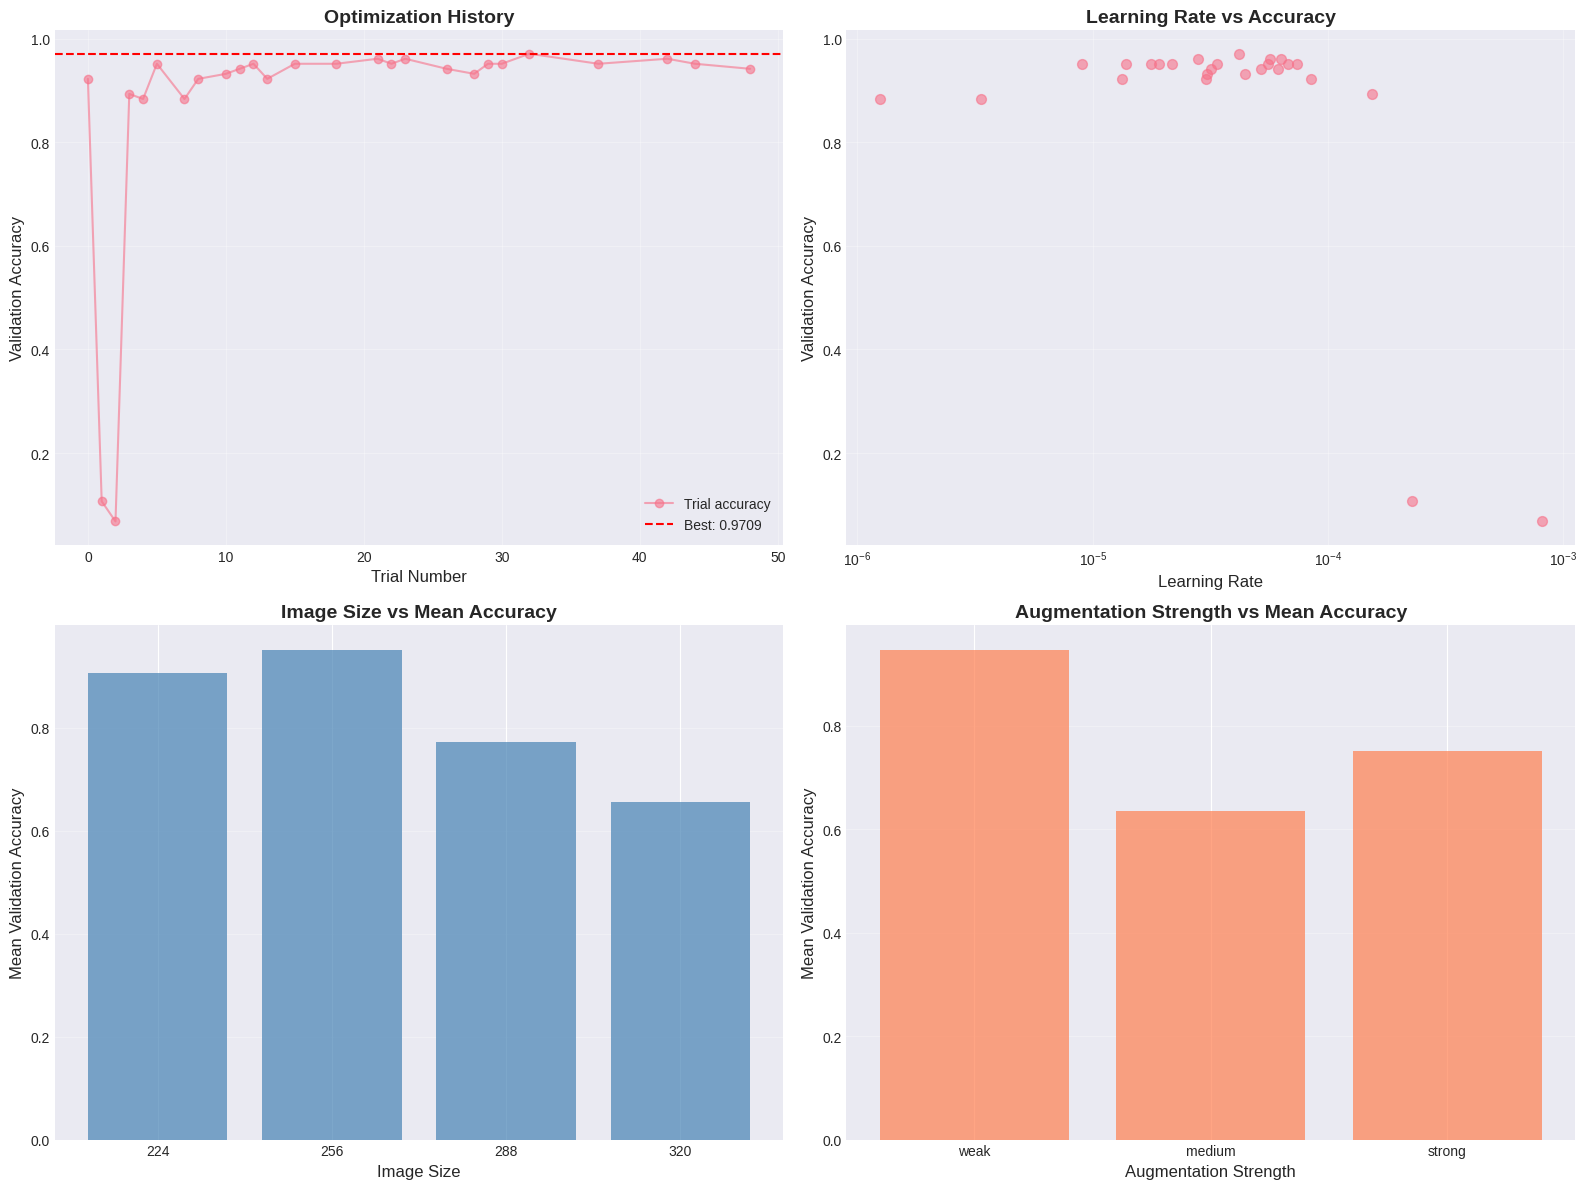

✓ Visualization saved


In [ ]:
# Optimization history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Optimization history
trial_numbers = [t.number for t in completed_trials]
trial_values = [t.value for t in completed_trials]

axes[0, 0].plot(trial_numbers, trial_values, 'o-', alpha=0.6, label='Trial accuracy')
axes[0, 0].axhline(best_trial.value, color='red', linestyle='--', label=f'Best: {best_trial.value:.4f}')
axes[0, 0].set_xlabel('Trial Number', fontsize=12)
axes[0, 0].set_ylabel('Validation Accuracy', fontsize=12)
axes[0, 0].set_title('Optimization History', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Parameter importance (learning rate vs accuracy)
lrs = [t.params['lr'] for t in completed_trials]
axes[0, 1].scatter(lrs, trial_values, alpha=0.6, s=50)
axes[0, 1].set_xscale('log')
axes[0, 1].set_xlabel('Learning Rate', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy', fontsize=12)
axes[0, 1].set_title('Learning Rate vs Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Image size distribution
img_sizes = [t.params['img_size'] for t in completed_trials]
img_size_accs = {}
for size in set(img_sizes):
    accs = [t.value for t in completed_trials if t.params['img_size'] == size]
    img_size_accs[size] = np.mean(accs)

sizes_sorted = sorted(img_size_accs.keys())
mean_accs = [img_size_accs[s] for s in sizes_sorted]

axes[1, 0].bar([str(s) for s in sizes_sorted], mean_accs, color='steelblue', alpha=0.7)
axes[1, 0].set_xlabel('Image Size', fontsize=12)
axes[1, 0].set_ylabel('Mean Validation Accuracy', fontsize=12)
axes[1, 0].set_title('Image Size vs Mean Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Augmentation strength
aug_strengths = ['weak', 'medium', 'strong']
aug_accs = {}
for strength in aug_strengths:
    accs = [t.value for t in completed_trials if t.params['aug_strength'] == strength]
    if accs:
        aug_accs[strength] = np.mean(accs)

if aug_accs:
    axes[1, 1].bar(list(aug_accs.keys()), list(aug_accs.values()), color='coral', alpha=0.7)
    axes[1, 1].set_xlabel('Augmentation Strength', fontsize=12)
    axes[1, 1].set_ylabel('Mean Validation Accuracy', fontsize=12)
    axes[1, 1].set_title('Augmentation Strength vs Mean Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(CONFIG['results_dir'], 'optuna_analysis.png'),
    dpi=150, bbox_inches='tight'
)
plt.show()

print('✓ Visualization saved')

In [ ]:
# Optuna built-in visualizations
try:
    from optuna.visualization import (
        plot_optimization_history,
        plot_param_importances,
        plot_parallel_coordinate,
        plot_slice
    )

    # Parameter importance
    fig = plot_param_importances(study)
    fig.write_image(os.path.join(CONFIG['results_dir'], 'param_importance.png'))
    fig.show()

    # Parallel coordinate plot
    fig = plot_parallel_coordinate(study)
    fig.write_image(os.path.join(CONFIG['results_dir'], 'parallel_coordinate.png'))
    fig.show()

    print('✓ Optuna visualizations saved')

except ImportError:
    print('⚠️ Install plotly for advanced visualizations: pip install plotly kaleido')

NameError: name 'study' is not defined

## 8. Train Final Model with Best Hyperparameters

In [ ]:
print("\n" + "#"*80)
print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
print("#"*80)

# best_params = best_trial.params
best_params = {
        'lr': 4.1698160076385435e-05,
        'weight_decay': 0.0003806007409400812,
        'optimizer': 'adamw',
        'scheduler': 'onecycle',
        'img_size': 256,
        'batch_size': 24,
        'aug_strength': 'weak',
        'mixup_alpha': 0.33423426210357904,
        'cutmix_alpha': 0.3742605686709749,
        'use_mixup': True,
        'use_cutmix': False,
        'label_smoothing': 0.0913645657315409,
        'drop_path_rate': 0.049511999955939134,
}

# Create datasets with best parameters
train_dataset_final = BirdDataset(
    train_df,
    CONFIG['train_images'],
    get_transforms(best_params['img_size'], 'train', best_params['aug_strength'])
)

val_dataset_final = BirdDataset(
    val_df,
    CONFIG['val_images'],
    get_transforms(best_params['img_size'], 'val')
)

train_loader_final = DataLoader(
    train_dataset_final,
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader_final = DataLoader(
    val_dataset_final,
    batch_size=best_params['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print(f"\nTraining with:")
print(f"  Image size: {best_params['img_size']}")
print(f"  Batch size: {best_params['batch_size']}")
print(f"  Learning rate: {best_params['lr']:.2e}")
print(f"  MixUp alpha: {best_params['mixup_alpha']:.2f}")
print(f"  CutMix alpha: {best_params['cutmix_alpha']:.2f}")
print(f"  Label smoothing: {best_params['label_smoothing']:.2f}")
print(f"  Augmentation: {best_params['aug_strength']}")


################################################################################
TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS
################################################################################

Training with:
  Image size: 256
  Batch size: 24
  Learning rate: 4.17e-05
  MixUp alpha: 0.33
  CutMix alpha: 0.37
  Label smoothing: 0.09
  Augmentation: weak


In [ ]:
# Train for full epochs
FINAL_EPOCHS = 40

model_final = timm.create_model(
    'convnext_tiny',
    pretrained=True,
    num_classes=NUM_CLASSES,
    drop_path_rate=best_params['drop_path_rate']
)
model_final = model_final.to(device)

criterion_final = LabelSmoothingCrossEntropy(epsilon=best_params['label_smoothing'])

if best_params['optimizer'] == 'adamw':
    optimizer_final = torch.optim.AdamW(
        model_final.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
else:
    optimizer_final = torch.optim.Adam(
        model_final.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )

if best_params['scheduler'] == 'cosine':
    scheduler_final = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer_final, T_max=FINAL_EPOCHS, eta_min=1e-6
    )
elif best_params['scheduler'] == 'step':
    scheduler_final = torch.optim.lr_scheduler.StepLR(
        optimizer_final, step_size=FINAL_EPOCHS//3, gamma=0.1
    )
else:
    scheduler_final = torch.optim.lr_scheduler.OneCycleLR(
        optimizer_final,
        max_lr=best_params['lr'],
        epochs=FINAL_EPOCHS,
        steps_per_epoch=len(train_loader_final)
    )

print(f"\nTraining for {FINAL_EPOCHS} epochs...")

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Training for 40 epochs...


In [ ]:
# Training loop
best_val_acc_final = 0.0
history_final = {'train_loss': [], 'val_acc': []}

for epoch in range(FINAL_EPOCHS):
    print(f"\nEpoch {epoch+1}/{FINAL_EPOCHS}")

    # Train
    model_final.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader_final, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        # MixUp/CutMix
        r = np.random.rand()
        if best_params['use_mixup'] and r < 0.4 and best_params['mixup_alpha'] > 0:
            images, labels_a, labels_b, lam = mixup_data(images, labels, best_params['mixup_alpha'])
            use_mixed = True
        elif best_params['use_cutmix'] and r < 0.8 and best_params['cutmix_alpha'] > 0:
            images, labels_a, labels_b, lam = cutmix_data(images, labels, best_params['cutmix_alpha'])
            use_mixed = True
        else:
            use_mixed = False

        optimizer_final.zero_grad()
        outputs = model_final(images)

        if use_mixed:
            loss = mixed_criterion(criterion_final, outputs, labels_a, labels_b, lam)
        else:
            loss = criterion_final(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_final.parameters(), max_norm=1.0)
        optimizer_final.step()

        if best_params['scheduler'] == 'onecycle':
            scheduler_final.step()

        train_loss += loss.item()

    if best_params['scheduler'] != 'onecycle':
        scheduler_final.step()

    # Validate
    model_final.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader_final, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model_final(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = correct / total
    avg_loss = train_loss / len(train_loader_final)

    history_final['train_loss'].append(avg_loss)
    history_final['val_acc'].append(val_acc)

    print(f"Train Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc_final:
        best_val_acc_final = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_final.state_dict(),
            'optimizer_state_dict': optimizer_final.state_dict(),
            'val_acc': val_acc,
            'hyperparameters': best_params
        }, os.path.join(CONFIG['checkpoint_dir'], 'optuna_best_model.pth'))
        print(f"✓ Best model saved: {val_acc:.4f}")

print(f"\n{'='*70}")
print(f"FINAL TRAINING COMPLETE!")
print(f"Best Validation Accuracy: {best_val_acc_final:.4f}")
print(f"{'='*70}")


Epoch 1/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 3.1371, Val Acc: 0.0777
✓ Best model saved: 0.0777

Epoch 2/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.8682, Val Acc: 0.2816
✓ Best model saved: 0.2816

Epoch 3/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.2636, Val Acc: 0.6990
✓ Best model saved: 0.6990

Epoch 4/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.5646, Val Acc: 0.8738
✓ Best model saved: 0.8738

Epoch 5/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1442, Val Acc: 0.8835
✓ Best model saved: 0.8835

Epoch 6/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0513, Val Acc: 0.9029
✓ Best model saved: 0.9029

Epoch 7/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0857, Val Acc: 0.8738

Epoch 8/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0664, Val Acc: 0.8835

Epoch 9/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8868, Val Acc: 0.9029

Epoch 10/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9622, Val Acc: 0.9417
✓ Best model saved: 0.9417

Epoch 11/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8702, Val Acc: 0.9223

Epoch 12/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8870, Val Acc: 0.9029

Epoch 13/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1feb9a32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1feb9a32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.9279, Val Acc: 0.9223

Epoch 14/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8043, Val Acc: 0.8835

Epoch 15/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7688, Val Acc: 0.9126

Epoch 16/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8134, Val Acc: 0.9223

Epoch 17/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1feb9a32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1feb9a32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.7431, Val Acc: 0.9417

Epoch 18/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8463, Val Acc: 0.9126

Epoch 19/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8062, Val Acc: 0.8835

Epoch 20/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8407, Val Acc: 0.9417

Epoch 21/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1feb9a32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1feb9a32e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.7891, Val Acc: 0.9223

Epoch 22/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7649, Val Acc: 0.9515
✓ Best model saved: 0.9515

Epoch 23/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7967, Val Acc: 0.9320

Epoch 24/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7588, Val Acc: 0.9320

Epoch 25/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8391, Val Acc: 0.9223

Epoch 26/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7145, Val Acc: 0.9223

Epoch 27/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7024, Val Acc: 0.9223

Epoch 28/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7686, Val Acc: 0.9612
✓ Best model saved: 0.9612

Epoch 29/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6914, Val Acc: 0.9417

Epoch 30/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6802, Val Acc: 0.9417

Epoch 31/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7470, Val Acc: 0.9515

Epoch 32/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7052, Val Acc: 0.9223

Epoch 33/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7652, Val Acc: 0.9320

Epoch 34/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7854, Val Acc: 0.9320

Epoch 35/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8237, Val Acc: 0.9417

Epoch 36/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7525, Val Acc: 0.9515

Epoch 37/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8161, Val Acc: 0.9320

Epoch 38/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7251, Val Acc: 0.9320

Epoch 39/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6886, Val Acc: 0.9223

Epoch 40/40


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6331, Val Acc: 0.9223

FINAL TRAINING COMPLETE!
Best Validation Accuracy: 0.9612


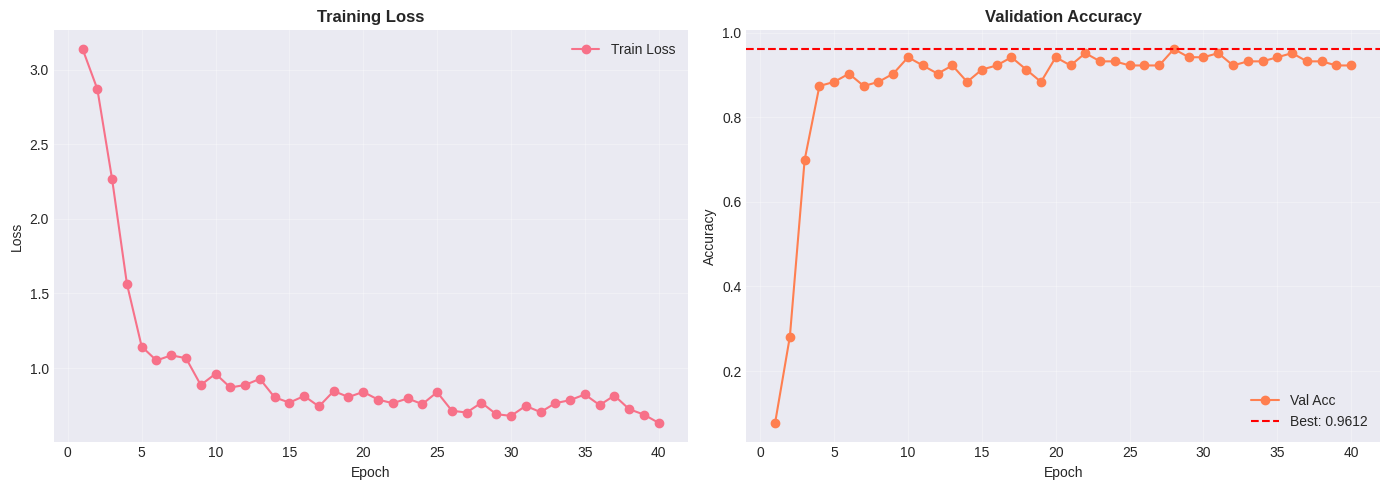

✓ Training curves saved


In [ ]:
# Plot final training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history_final['val_acc']) + 1)

axes[0].plot(epochs_range, history_final['train_loss'], marker='o', label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs_range, history_final['val_acc'], marker='o', color='coral', label='Val Acc')
axes[1].axhline(best_val_acc_final, color='red', linestyle='--', label=f'Best: {best_val_acc_final:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(CONFIG['results_dir'], 'final_training_curves.png'),
    dpi=150, bbox_inches='tight'
)
plt.show()

print('✓ Training curves saved')

## 9. Generate Submission

In [ ]:
# Load best model
checkpoint = torch.load(os.path.join(CONFIG['checkpoint_dir'], 'optuna_best_model.pth'))
model_final.load_state_dict(checkpoint['model_state_dict'])
model_final = model_final.to(device)
model_final.eval()

print(f"Best model loaded: Val Acc = {checkpoint['val_acc']:.4f}")

Best model loaded: Val Acc = 0.9612


In [ ]:
def predict_with_tta(model, image, n_tta=5):
    """
    Test-time augmentation for better predictions
    """
    model.eval()

    # TTA transforms
    tta_transforms = [
        get_transforms(best_params['img_size'], 'val'),  # Original
        A.Compose([A.HorizontalFlip(p=1.0)] +
                 get_transforms(best_params['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=10, p=1.0)] +
                 get_transforms(best_params['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=-10, p=1.0)] +
                 get_transforms(best_params['img_size'], 'val').transforms),
        A.Compose([A.RandomBrightnessContrast(p=1.0)] +
                 get_transforms(best_params['img_size'], 'val').transforms),
    ]

    predictions = []

    with torch.no_grad():
        for transform in tta_transforms[:n_tta]:
            augmented = transform(image=image)['image']
            augmented = augmented.unsqueeze(0).to(device)

            output = model(augmented)
            probs = F.softmax(output, dim=1)
            predictions.append(probs.cpu().numpy())

    # Average predictions
    avg_pred = np.mean(predictions, axis=0)
    return avg_pred

Transform ready: True
Found 400 test images
Running TTA predictions...


  0%|          | 0/400 [00:00<?, ?it/s]

✓ Saved /content/drive/MyDrive/ml_results/phase2b_results/submission_phase2b_optuna_tta.csv
Predictions: 400
0     19
1     17
2     24
3     20
4     22
5     21
6     15
7     21
8     19
9     25
10    19
11    18
12    12
13    24
14    20
15    26
16    22
17    20
18    18
19    18
Name: count, dtype: int64


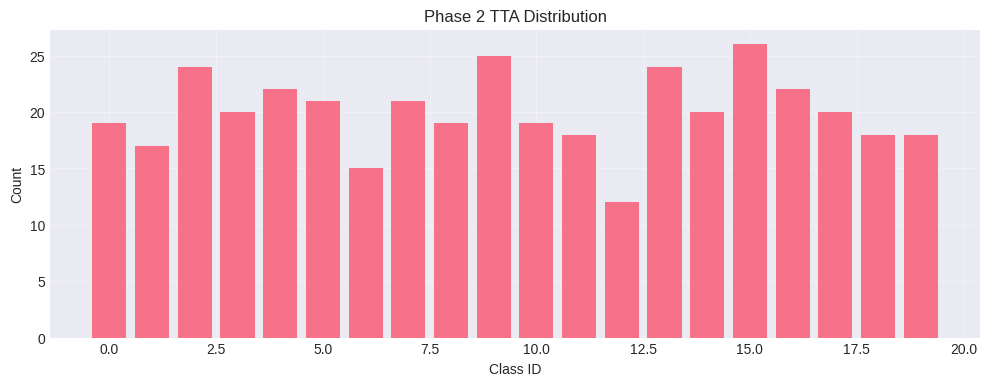

In [ ]:
test_transform = get_transforms(best_params['img_size'], 'val')
print(f"Transform ready: {test_transform is not None}")

test_image_paths = []
for root, dirs, files in os.walk(CONFIG['test_images']):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_image_paths.append(os.path.join(root, file))

print(f"Found {len(test_image_paths)} test images")

# Generate predictions
predictions = []
print("Running TTA predictions...")

for img_path in tqdm(test_image_paths):
    # Safe loading matching your original
    image = cv2.imread(img_path)
    if image is None or image.size == 0:
        image = np.zeros((best_params['img_size'], best_params['img_size'], 3), dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    avg_pred = predict_with_tta(model_final, image, n_tta=5)
    predictions.append(int(np.argmax(avg_pred)))

# Save submission
submission = pd.DataFrame({
    'path': [os.path.basename(p) for p in test_image_paths],
    'class_idx': predictions
})

submission_path = os.path.join(CONFIG['results_dir'], f'submission_phase2b_optuna_tta.csv')
submission.to_csv(submission_path, index=False)

print(f"✓ Saved {submission_path}")
print(f"Predictions: {len(predictions)}")
print(pd.Series(predictions).value_counts().sort_index())

# 5. Plot
plt.figure(figsize=(12, 4))
plt.bar(pd.Series(predictions).value_counts().sort_index().index,
        pd.Series(predictions).value_counts().sort_index().values)
plt.title('Phase 2 TTA Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase2b_tta_dist.png'), dpi=150)
plt.show()
